# C3.ai COVID-19 Data Lake

This Jupyter notebook uses [C3.ai COVID-19 Data Lake](https://c3.ai/covid/) APIs to perform an exploratory analysis of the Coronavirus epidemic using recent clinical and demographic data from various academic and global health institutions. The notebook includes both custom code, as well as code taken from C3.ai's helper templates [found here](https://c3.ai/covid-19-api-documentation/#section/Quickstart-Guide/Python-Quickstart). The primary purpose of this project is to show how we can query diverse online data sources to make unique insights. We'll conclude by using API calls to retrieve the specific information that will be usefull in making a predictive machine learning model [found here](https://github.com/edsto1/Covid19_Analysis_and_Insights/blob/master/Deep_Learning_ANN_Predictive_Model.ipynb).

In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np

<a id="helpers"></a>
## Helper methods for accessing the API

The helper templates below (provided by C3.ai) show us how to convert a JSON response from the C3.ai APIs to a Pandas DataFrame, allowing us to explore our own unique insights. This cell should be run before querying the API

In [2]:
def read_data_json(typename, api, body):
    """
    read_data_json directly accesses the C3.ai COVID-19 Data Lake APIs using the requests library, 
    and returns the response as a JSON, raising an error if the call fails for any reason.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    api: The API you want to access, either 'fetch' or 'evalmetrics'.
    body: The spec you want to pass. For examples, see the API documentation.
    """
    response = requests.post(
        "https://api.c3.ai/covid/api/1/" + typename + "/" + api, 
        json = body, 
        headers = {
            'Accept' : 'application/json', 
            'Content-Type' : 'application/json'
        }
    )
    response.raise_for_status()
    
    return response.json()

def fetch(typename, body, get_all = False, remove_meta = True):
    """
    fetch accesses the C3.ai COVID-19 Data Lake using read_data_json, and converts the response into a Pandas dataframe. 
    fetch is used for all non-timeseries data in the C3.ai COVID-19 Data Lake, and will call read_data as many times 
    as required to access all of the relevant data for a given typename and body.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    body: The spec you want to pass. For examples, see the API documentation.
    get_all: If True, get all records and ignore any limit argument passed in the body. If False, use the limit argument passed in the body. The default is False.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """
    if get_all:
        has_more = True
        offset = 0
        limit = 2000
        df = pd.DataFrame()

        while has_more:
            body['spec'].update(limit = limit, offset = offset)
            response_json = read_data_json(typename, 'fetch', body)
            new_df = pd.json_normalize(response_json['objs'])
            df = df.append(new_df)
            has_more = response_json['hasMore']
            offset += limit
            
    else:
        response_json = read_data_json(typename, 'fetch', body)
        df = pd.json_normalize(response_json['objs'])
        
    if remove_meta:
        df = df.drop(columns = [c for c in df.columns if ('meta' in c) | ('version' in c)])
    
    return df
    
def evalmetrics(typename, body, get_all = False, remove_meta = True):
    """
    evalmetrics accesses the C3.ai COVID-19 Data Lake using read_data_json, and converts the response into a Pandas dataframe.
    evalmetrics is used for all timeseries data in the C3.ai COVID-19 Data Lake.
    ------
    typename: The type you want to access, i.e. 'OutbreakLocation', 'LineListRecord', 'BiblioEntry', etc.
    body: The spec you want to pass. For examples, see the API documentation.
    get_all: If True, get all metrics and ignore limits on number of expressions and ids. If False, consider expressions and ids limits. The default is False.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """
    if get_all:
        expressions = body['spec']['expressions']
        ids = body['spec']['ids']
        df = pd.DataFrame()
        
        for ids_start in range(0, len(ids), 10):
            for expressions_start in range(0, len(expressions), 4):
                body['spec'].update(
                    ids = ids[ids_start : ids_start + 10],
                    expressions = expressions[expressions_start : expressions_start + 4]
                )
                response_json = read_data_json(typename, 'evalmetrics', body)
                new_df = pd.json_normalize(response_json['result'])
                new_df = new_df.apply(pd.Series.explode)
                df = pd.concat([df, new_df], axis = 1)
            
    else:
        response_json = read_data_json(typename, 'evalmetrics', body)
        df = pd.json_normalize(response_json['result'])
        df = df.apply(pd.Series.explode)

    # get the useful data out
    if remove_meta:
        df = df.filter(regex = 'dates|data|missing')
    
    # only keep one date column
    date_cols = [col for col in df.columns if 'dates' in col]
    keep_cols =  date_cols[:1] + [col for col in df.columns if 'dates' not in col]
    df = df.filter(items = keep_cols).rename(columns = {date_cols[0] : "dates"})
    df["dates"] = pd.to_datetime(df["dates"])
    
    return df

def getprojectionhistory(body, remove_meta = True):
    """
    getprojectionhistory accesses the C3.ai COVID-19 Data Lake using read_data_json, and converts the response into a Pandas dataframe.
    ------
    body: The spec you want to pass. For examples, see the API documentation.
    remove_meta: If True, remove metadata about each record. If False, include it. The default is True.
    """  
    response_json = read_data_json("outbreaklocation", 'getprojectionhistory', body)
    df = pd.json_normalize(response_json)
    df = df.apply(pd.Series.explode)

    # get the useful data out
    if remove_meta:
        df = df.filter(regex = 'dates|data|missing|expr')
    
    # only keep one date column
    date_cols = [col for col in df.columns if 'dates' in col]
    keep_cols =  date_cols[:1] + [col for col in df.columns if 'dates' not in col]
    df = df.filter(items = keep_cols).rename(columns = {date_cols[0] : "dates"})
    df["dates"] = pd.to_datetime(df["dates"])
    
    # rename columns to simplify naming convention
    df = df.rename(columns = lambda x: x.replace(".value", ""))
    
    return df

<a id="outbreaklocation"></a>
## Get Outbreak Location data

OutbreakLocation stores location data such as countries, provinces, cities, where COVID-19 outbeaks have occured and are recorded. We can reference the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/OutbreakLocation) for details and for a list of available locations. In this case, we fetch information about Brazil.

In [3]:
# i.e. Fetch facts about Brazil
locations = fetch(
    "outbreaklocation",
    {
        "spec" : {
            "filter" : "id == 'Brazil'"
        }
    }
)

locations

,latestTotalPopulation,populationOfAllChildren,locationType,populationCDS,countryArea,countryCode,population2018,id,name,typeIdent,hospitalPrediction.timestamp,location.value.id,location.timestamp,fips.id
0,232304177.0,232304177.0,country,208494900,8358140.0,BR,209469333,Brazil,Brazil,EP_LOC,2019-01-01T00:00:00,Brazil,2020-05-18T00:00:00Z,BR


<a id="outbreaklocation/casecounts"></a>
### Case counts

We'll retrieve ounts of cases, deaths, recoveries, and other statistics for counties (Hennepin County, MN specifically), provinces, and countries worldwide via John Hopkins, The EDCD, or Covid Tracking Project.

In [4]:
# Total number of confirmed cases, deaths, and recoveries in Hennepin County, Minnesota
today = pd.Timestamp.now().strftime("%Y-%m-%d")

casecounts = evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : ["Hennepin_Minnesota_UnitedStates"],
            "expressions" : ["JHU_ConfirmedCases", "JHU_ConfirmedDeaths", "JHU_ConfirmedRecoveries"],
            "start" : "2020-01-01",
            "end" : today,
            "interval" : "DAY",
        }
    }
)

casecounts

,dates,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.data,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.missing,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.data,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.missing,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.data,Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.missing
0,2020-01-01,0,0,0,0,0,100
0,2020-01-02,0,0,0,0,0,100
0,2020-01-03,0,0,0,0,0,100
0,2020-01-04,0,0,0,0,0,100
0,2020-01-05,0,0,0,0,0,100
...,...,...,...,...,...,...,...
0,2020-07-09,12867,0,789,0,0,0
0,2020-07-10,13054,0,790,0,0,0
0,2020-07-11,13328,0,790,0,0,0
0,2020-07-12,13568,0,791,0,0,0


Plot these counts.

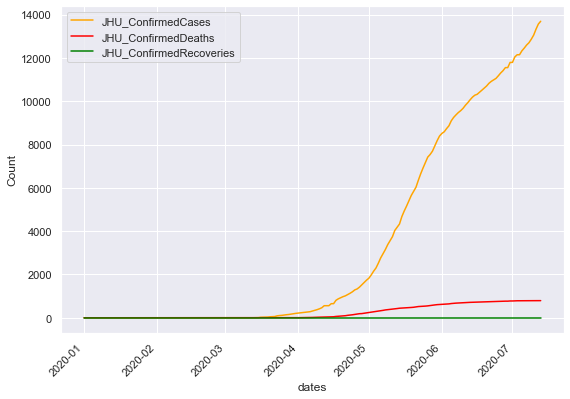

In [5]:
import seaborn as sns
plt.figure(figsize = (9, 6))


casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.data"] = casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.data"].astype(int)

casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.data"]=casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.data"].astype(int)

casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.data"]=casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.data"].astype(int)

sns.set()
sns.lineplot(
    x=casecounts["dates"],
    y=casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedCases.data"],
    label = "JHU_ConfirmedCases", color='orange'
    
)
sns.lineplot(
    x=casecounts["dates"],
    y=casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedDeaths.data"],
    label = "JHU_ConfirmedDeaths", color='red'
    
)
sns.lineplot(
    x=casecounts["dates"],
    y=casecounts["Hennepin_Minnesota_UnitedStates.JHU_ConfirmedRecoveries.data"],
    label = "JHU_ConfirmedRecoveries", color='green'
   
)


plt.legend()
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Count")
plt.show()

Export case counts as a .csv file.

In [6]:
# Uncomment the line below to export the DataFrame as a .csv file
# casecounts.to_csv("casecounts.csv")

<a id="outbreaklocation/demographics"></a>
### Demographics

Demographic and economic data from the US Census Bureau and The World Bank allow demographic comparisons across locations. This sections uses C3.ai's API Fetch template to get and visualize the age distributioin of a country as it relates to its proportionality of Covid19 cases. (*Code in this "Demographics" section was obtained from C3.ai's API helper method template [found here](https://c3.ai/covid-19-api-documentation/#section/Quickstart-Guide/Python-Quickstart)

In [7]:
population = fetch(
    "populationdata",
    {
        "spec" : {
            "filter" : "!contains(parent, '_') && (populationAge == '>=65' || populationAge == 'Total') && gender == 'Male/Female' && year == '2018' && estimate == 'False' && percent == 'False'"
        }
    },
    get_all = True
)

population

,year,gender,populationAge,estimate,median,percent,value,minAge,origin,id,timestamp,parent.id
0,2018,Male/Female,>=65,False,False,False,960879.0,65.0,World Bank,2018_Afghanistan_Male/Female_>=65_Count_SP.POP...,2018-01-01T00:00:00Z,Afghanistan
1,2018,Male/Female,Total,False,False,False,37172386.0,NaN,World Bank,2018_Afghanistan_Male/Female_Total_Count_SP.PO...,2018-01-01T00:00:00Z,Afghanistan
2,2018,Male/Female,>=65,False,False,False,393976.0,65.0,World Bank,2018_Albania_Male/Female_>=65_Count_SP.POP.65U...,2018-01-01T00:00:00Z,Albania
3,2018,Male/Female,Total,False,False,False,2866376.0,NaN,World Bank,2018_Albania_Male/Female_Total_Count_SP.POP.TOTL,2018-01-01T00:00:00Z,Albania
4,2018,Male/Female,>=65,False,False,False,2686782.0,65.0,World Bank,2018_Algeria_Male/Female_>=65_Count_SP.POP.65U...,2018-01-01T00:00:00Z,Algeria
...,...,...,...,...,...,...,...,...,...,...,...,...
479,2018,Male/Female,Total,False,False,False,28498687.0,NaN,World Bank,2018_Yemen_Male/Female_Total_Count_SP.POP.TOTL,2018-01-01T00:00:00Z,Yemen
480,2018,Male/Female,>=65,False,False,False,364332.0,65.0,World Bank,2018_Zambia_Male/Female_>=65_Count_SP.POP.65UP.TO,2018-01-01T00:00:00Z,Zambia
481,2018,Male/Female,Total,False,False,False,17351822.0,NaN,World Bank,2018_Zambia_Male/Female_Total_Count_SP.POP.TOTL,2018-01-01T00:00:00Z,Zambia
482,2018,Male/Female,>=65,False,False,False,424438.0,65.0,World Bank,2018_Zimbabwe_Male/Female_>=65_Count_SP.POP.65...,2018-01-01T00:00:00Z,Zimbabwe


In [8]:
population_age_distribution = population.loc[
    :, 
    ["populationAge", "parent.id", "value"]
].pivot(index = "parent.id", columns = "populationAge")['value']
population_age_distribution["proportion_over_65"] = population_age_distribution[">=65"] / population_age_distribution["Total"]

population_age_distribution

populationAge,>=65,Total,proportion_over_65
parent.id,,,
Afghanistan,960879.0,3.717239e+07,0.025849
Albania,393976.0,2.866376e+06,0.137447
Algeria,2686782.0,4.222843e+07,0.063625
Andorra,NaN,7.700600e+04,NaN
Angola,682859.0,3.080976e+07,0.022164
...,...,...,...
WestBankandGaza,143163.0,4.569087e+06,0.031333
World,673618927.0,7.594270e+09,0.088701
Yemen,819699.0,2.849869e+07,0.028763


### Get world wide death counts as of July 12th.

In [9]:
global_deaths = evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : list(population_age_distribution.index),
            "expressions" : ["JHU_ConfirmedDeaths"],
            "start" : "2020-07-12",
            "end" : "2020-07-12",
            "interval" : "DAY",
        }
    },
    get_all = True
)

global_deaths

,dates,Armenia.JHU_ConfirmedDeaths.data,Armenia.JHU_ConfirmedDeaths.missing,Afghanistan.JHU_ConfirmedDeaths.data,Afghanistan.JHU_ConfirmedDeaths.missing,Argentina.JHU_ConfirmedDeaths.data,Argentina.JHU_ConfirmedDeaths.missing,Angola.JHU_ConfirmedDeaths.data,Angola.JHU_ConfirmedDeaths.missing,AntiguaandBarbuda.JHU_ConfirmedDeaths.data,...,WestBankandGaza.JHU_ConfirmedDeaths.data,WestBankandGaza.JHU_ConfirmedDeaths.missing,UnitedStates.JHU_ConfirmedDeaths.data,UnitedStates.JHU_ConfirmedDeaths.missing,Yemen.JHU_ConfirmedDeaths.data,Yemen.JHU_ConfirmedDeaths.missing,Zimbabwe.JHU_ConfirmedDeaths.data,Zimbabwe.JHU_ConfirmedDeaths.missing,Zambia.JHU_ConfirmedDeaths.data,Zambia.JHU_ConfirmedDeaths.missing
0,2020-07-12,565,0,1010,0,1845,0,26,0,3,...,36,0,153201,0,417,0,18,0,42,0


In [10]:
global_deaths_by_country = global_deaths.filter(regex=("\.data")).melt()
global_deaths_by_country["country"] = global_deaths_by_country["variable"].str.replace("\..*", "")

global_comparison = global_deaths_by_country.set_index("country").join(population_age_distribution)
global_comparison["deaths_per_million"] = 1e6 * global_comparison["value"] / global_comparison["Total"] 
global_comparison

,variable,value,>=65,Total,proportion_over_65,deaths_per_million
country,,,,,,
Armenia,Armenia.JHU_ConfirmedDeaths.data,565,332187.0,2951776.0,0.112538,191.41
Afghanistan,Afghanistan.JHU_ConfirmedDeaths.data,1010,960879.0,37172386.0,0.025849,27.1707
Argentina,Argentina.JHU_ConfirmedDeaths.data,1845,4946805.0,44494502.0,0.111178,41.4658
Angola,Angola.JHU_ConfirmedDeaths.data,26,682859.0,30809762.0,0.022164,0.843888
AntiguaandBarbuda,AntiguaandBarbuda.JHU_ConfirmedDeaths.data,3,8473.0,96286.0,0.087998,31.1572
...,...,...,...,...,...,...
WestBankandGaza,WestBankandGaza.JHU_ConfirmedDeaths.data,36,143163.0,4569087.0,0.031333,7.87904
UnitedStates,UnitedStates.JHU_ConfirmedDeaths.data,153201,51641630.0,326687501.0,0.158077,468.953
Yemen,Yemen.JHU_ConfirmedDeaths.data,417,819699.0,28498687.0,0.028763,14.6323


Visualize the results.

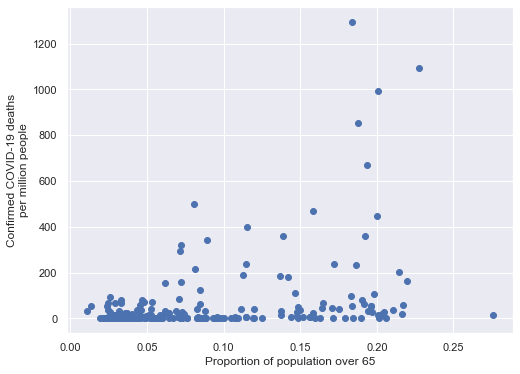

In [11]:
plt.figure(figsize = (8, 6))
plt.scatter(
    global_comparison["proportion_over_65"],
    global_comparison["deaths_per_million"]
)
plt.xlabel("Proportion of population over 65")
plt.ylabel("Confirmed COVID-19 deaths\nper million people")
plt.show()

<a id="linelistrecord"></a>
## Get LineListRecord data

LineListRecord stores row-level crowdsourced data from laboratory-confirmed COVID-19 patients. This data includes gender, age, symptoms, travel history, location, reported onset, confirmation dates, and discharge status. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LineListRecord) for details. (*Code in this "Demographics" section was obtained from C3.ai's API helper method template [found here](https://c3.ai/covid-19-api-documentation/#section/Quickstart-Guide/Python-Quickstart)

In [12]:
# Fetch the line list records tracked by MOBS Lab
records = fetch(
    "linelistrecord",
    {
        "spec" : {
            "filter" : "lineListSource == 'DXY'"
        }
    },
    get_all = True
)

#print(records.columns.values)
records

,age,gender,symptomStartDate,exposureStartDate,exposureEndDate,hospitalAdmissionDate,caseConfirmationDate,livesInGroundZero,traveledToGroundZero,traveler,...,outcome,didDie,didRecover,recordSource,lineListSource,hasTravelHistory,id,location.id,caseInCountry,symptoms
0,66.0,male,2020-01-03T00:00:00Z,2019-12-29T00:00:00Z,2020-01-04T00:00:00Z,2020-01-11T00:00:00Z,2020-01-20T00:00:00Z,False,False,False,...,open,False,False,Shenzhen Municipal Health Commission: http://w...,DXY,False,1,ShenzhenGuangdong_China,NaN,NaN
1,56.0,male,2020-01-16T00:00:00Z,2020-01-08T00:00:00Z,2020-01-16T00:00:00Z,2020-01-20T00:00:00Z,2020-01-21T00:00:00Z,False,False,False,...,open,False,False,Beijing Municipal Health Commission: http://wj...,DXY,False,10,Beijing_China,NaN,NaN
2,70.0,male,2020-01-15T00:00:00Z,NaN,NaN,2020-01-19T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,央视新闻: https://m.weibo.cn/status/4464497211305006?,DXY,False,100,WuhanHubei_China,NaN,NaN
3,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,1000,UnitedStates,56.0,NaN
4,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,1001,UnitedStates,57.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,995,UnitedStates,51.0,NaN
1393,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,996,UnitedStates,52.0,NaN
1394,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-24T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,997,UnitedStates,53.0,NaN
1395,NaN,other,NaN,NaN,2020-02-13T00:00:00Z,NaN,2020-02-25T00:00:00Z,False,False,False,...,open,False,False,1Point3Acres: https://coronavirus.1point3acres...,DXY,False,998,UnitedStates,54.0,NaN


What are the most common symptoms in the dataset?

In [13]:
# Get all the symptoms, which are initially comma-separated
symptom_df = records.copy()
symptom_df["symptoms"] = symptom_df["symptoms"].str.split(", ")
symptom_df = symptom_df.explode("symptoms")
symptom_df = symptom_df.dropna(subset = ["symptoms"])
symptom_freq = symptom_df.groupby(["symptoms"]).agg("count")[["id"]].sort_values("id")

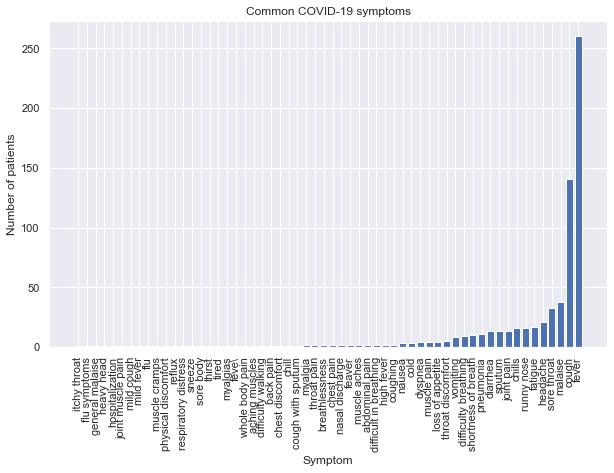

In [14]:
# Plot the data
plt.figure(figsize = (10, 6))
plt.bar(symptom_freq.index, symptom_freq["id"])
plt.xticks(rotation = 90)
plt.xlabel("Symptom")
plt.ylabel("Number of patients")
plt.title("Common COVID-19 symptoms")
plt.show()

How long does it take for a symptomatic person to become hospitalized after developing symptoms?

In [15]:
# Drop null values/records from the desired columns
hospitalized = records.dropna(subset = ["hospitalAdmissionDate", "symptomStartDate"])

# Get the number of days from development of symptoms to hospitalization for each patient
hospitalization_time = np.array(
    pd.to_datetime(hospitalized['hospitalAdmissionDate']) - pd.to_datetime(hospitalized['symptomStartDate'])
).astype('timedelta64[D]').astype('float')
hospitalization_time = hospitalization_time[hospitalization_time >= 0]

# Hospitalization time of 0 days is replaced with 0.1 to indicate immediate hospitalization
hospitalization_time[hospitalization_time <= 0.1] = 0.1

hospitalized

,age,gender,symptomStartDate,exposureStartDate,exposureEndDate,hospitalAdmissionDate,caseConfirmationDate,livesInGroundZero,traveledToGroundZero,traveler,...,outcome,didDie,didRecover,recordSource,lineListSource,hasTravelHistory,id,location.id,caseInCountry,symptoms
0,66.0,male,2020-01-03T00:00:00Z,2019-12-29T00:00:00Z,2020-01-04T00:00:00Z,2020-01-11T00:00:00Z,2020-01-20T00:00:00Z,False,False,False,...,open,False,False,Shenzhen Municipal Health Commission: http://w...,DXY,False,1,ShenzhenGuangdong_China,NaN,NaN
1,56.0,male,2020-01-16T00:00:00Z,2020-01-08T00:00:00Z,2020-01-16T00:00:00Z,2020-01-20T00:00:00Z,2020-01-21T00:00:00Z,False,False,False,...,open,False,False,Beijing Municipal Health Commission: http://wj...,DXY,False,10,Beijing_China,NaN,NaN
2,70.0,male,2020-01-15T00:00:00Z,NaN,NaN,2020-01-19T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,央视新闻: https://m.weibo.cn/status/4464497211305006?,DXY,False,100,WuhanHubei_China,NaN,NaN
24,72.0,male,2020-01-11T00:00:00Z,NaN,NaN,2020-01-18T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,央视新闻: https://m.weibo.cn/status/4464497211305006?,DXY,False,102,WuhanHubei_China,NaN,NaN
35,79.0,male,2020-01-11T00:00:00Z,NaN,NaN,2020-01-17T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,央视新闻: https://m.weibo.cn/status/4464497211305006?,DXY,False,103,WuhanHubei_China,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,30.0,male,2020-01-16T00:00:00Z,NaN,2020-01-15T00:00:00Z,2020-01-19T00:00:00Z,2020-01-21T00:00:00Z,False,False,False,...,open,False,False,LA Times: https://www.latimes.com/california/s...,DXY,False,945,Washington_UnitedStates,1.0,NaN
1338,60.0,female,2020-01-16T00:00:00Z,NaN,2020-01-13T00:00:00Z,2020-01-16T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,LA Times: https://www.latimes.com/california/s...,DXY,False,946,Illinois_UnitedStates,2.0,NaN
1339,NaN,male,2020-01-22T00:00:00Z,NaN,NaN,2020-01-22T00:00:00Z,2020-01-26T00:00:00Z,False,False,False,...,open,False,False,LA Times: https://www.latimes.com/california/s...,DXY,False,947,California_UnitedStates,3.0,NaN
1342,56.0,female,2020-01-10T00:00:00Z,NaN,2020-01-12T00:00:00Z,2020-01-15T00:00:00Z,2020-01-24T00:00:00Z,False,False,False,...,open,False,False,人民日报: https://m.weibo.cn/status/4464354512805408?,DXY,False,95,Shanghai_China,NaN,NaN


16


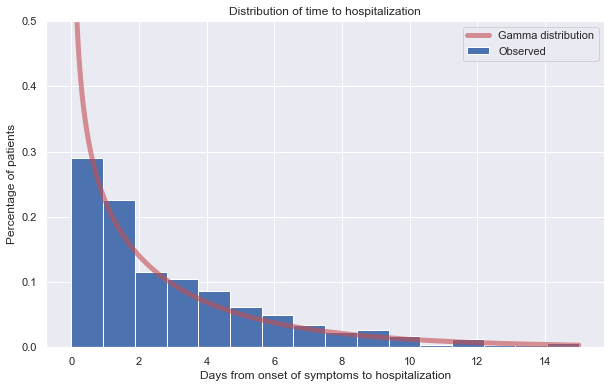

In [16]:
# Fit a gamma distribution
a, loc, scale = gamma.fit(hospitalization_time, floc = 0)
dist = gamma(a, loc, scale)

# Plot the results
x = np.linspace(0, np.max(hospitalization_time), 1000)
n_bins = int(np.max(hospitalization_time) + 1)
print(n_bins)

plt.figure(figsize = (10, 6))
plt.hist(
    hospitalization_time, 
    bins = n_bins, 
    range = (0, np.max(hospitalization_time)), 
    density = True, 
    label = "Observed"
)
plt.plot(x, dist.pdf(x), 'r-', lw=5, alpha=0.6, label = 'Gamma distribution')
plt.ylim(0, 0.5)
plt.xlabel("Days from onset of symptoms to hospitalization")
plt.ylabel("Percentage of patients")
plt.title("Distribution of time to hospitalization")
plt.legend()
plt.show()

 <br>

## Finding unique data to construct a predictive machine learning model with<br>
Now that we're more familiar with how to query the data from this API, we fetch from "linelistsrecord" (which gives us demographic data) with "lineListSource" set to "OPEN", so we get all all possible records. We'll use this row level data on Covid patients to make a Deep Learning model that will use several demographic and health features to predict the outcome of a new patient.

In [17]:
# Fetch the line list records tracked by nCoV2019 Data Working Group
records2 = fetch(
    "linelistrecord",
    {
        "spec" : {
            "filter" : "lineListSource == 'OPEN'"
        }
    },
    get_all = True
)

#print(records.columns.values)
pd.set_option('display.max_columns', None)
records2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266871 entries, 0 to 870
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   age                            11959 non-null   float64
 1   gender                         15510 non-null   object 
 2   caseConfirmationDate           263353 non-null  object 
 3   livesInGroundZero              266871 non-null  bool   
 4   traveledToGroundZero           266871 non-null  bool   
 5   recordSource                   247324 non-null  object 
 6   lineListSource                 266871 non-null  object 
 7   hasTravelHistory               266871 non-null  bool   
 8   id                             266871 non-null  object 
 9   location.id                    266848 non-null  object 
 10  locationType                   6868 non-null    object 
 11  groundZeroExposure             1350 non-null    object 
 12  notes                          83

### Save this DF to a csv

In [22]:
#records2['chronicDisease'].unique()
records2.to_csv('./files/Covid19_LineList_Records.csv')